# 06. Model Clustering: Training - PySpark

## 06.1. Importação das bibliotecas

### 06.1.1. Importando as bibliotecas nativas do Python

In [1]:
import sys

### 06.1.2. Importando as bibliotecas de terceiros

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession, types as T
from pyspark.sql.functions import *
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PowerTransformer, StandardScaler

### 06.1.3. Importando os módulos locais do projeto

In [3]:
sys.path.append('..')
import functions.fn_charts_pandas as fn_charts_pandas
import functions.fn_stats_pyspark as fn_stats_pyspark
import params.consts as consts

## 06.2. Visão geral dos dados

### 06.2.0. Iniciando a sessão Spark

In [4]:
spark = SparkSession.builder.appName('spark').getOrCreate()

### 06.2.1. Habilitando a exibição de todas as colunas

In [5]:
pd.set_option('display.max_columns', None)

### 06.2.2. Armazenando o dataset em uma variável

In [6]:
df = spark.read \
    .format('parquet') \
    .load(consts.DATASET_CLEAN_PYSPARK)

### 06.2.3. Visualizando a quantidade de linhas e colunas do dataset

In [7]:
(df.count(), len(df.columns))

(2205, 22)

### 06.2.4. Exibindo o dataset

In [8]:
df.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
|       PhD|        Single|       1|          1| 63|     61+|67680.0|      8|       0|                6

### 06.2.5. Visualizando os detalhes do dataset

In [9]:
df.printSchema()

root
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Children: integer (nullable = true)
 |-- HasChildren: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- AgeGroup: string (nullable = true)
 |-- Income: double (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Complain: integer (nullable = true)
 |-- Dt_Customer_Month: integer (nullable = true)
 |-- Dt_Customer_Quarter: integer (nullable = true)
 |-- Days_Since_Enrolled: integer (nullable = true)
 |-- Years_Since_Enrolled: long (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- NumTotalPurchases: integer (nullable = true)
 |-- MntRegularProds: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- MntTotal: integer (nullable = true)
 |-- AcceptedCmpTotal: integer (nullable = true)
 |-- HasAcceptedCmp: integer (nullable = true)
 |-- Response: integer (nullable = true)



### 06.2.6. Visualizando as estatísticas das colunas numéricas

In [10]:
fn_stats_pyspark.summary(df).show(truncate = False)

+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
|summary|Education|Marital_Status|Children|HasChildren|Age   |AgeGroup|Income  |Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|
+-------+---------+--------------+--------+-----------+------+--------+--------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
|count  |2205     |2205          |2205.0  |2205.0     |2205.0|2205    

### 06.2.7. Visualizando as estatísticas da colunas categóricas

In [11]:
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, T.StringType)]

df.describe(categorical_columns).show()

+-------+---------+--------------+--------+
|summary|Education|Marital_Status|AgeGroup|
+-------+---------+--------------+--------+
|  count|     2205|          2205|    2205|
|   mean|     NULL|          NULL|    NULL|
| stddev|     NULL|          NULL|    NULL|
|    min| 2n Cycle|       Partner|   18-30|
|    max|      PhD|        Single|     61+|
+-------+---------+--------------+--------+



### 06.2.8. Verificando as colunas com valores nulos

In [12]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
|Education|Marital_Status|Children|HasChildren|Age|AgeGroup|Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|
+---------+--------------+--------+-----------+---+--------+------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+
|        0|             0|       0|          0|  0|       0|     0|      0|       0|                0|       

## 06.3. Treinamento do modelo de clusterização

### 06.3.0. Convertendo o df PySpark para Pandas

In [13]:
df_pd = df.toPandas()

### 06.3.1. Listando as colunas numéricas e categóricas

In [14]:
numerical_features = df_pd.select_dtypes(include = 'number').columns 

print('Numerical Features:') 

for i in numerical_features:

    print(f'- {i}')

Numerical Features:
- Children
- HasChildren
- Age
- Income
- Recency
- Complain
- Dt_Customer_Month
- Dt_Customer_Quarter
- Days_Since_Enrolled
- Years_Since_Enrolled
- NumDealsPurchases
- NumWebVisitsMonth
- NumTotalPurchases
- MntRegularProds
- MntGoldProds
- MntTotal
- AcceptedCmpTotal
- HasAcceptedCmp
- Response


In [15]:
categorical_features = df_pd.select_dtypes(exclude = 'number').columns 

print('\nCategorical Features:') 

for i in categorical_features:
    
    print(f'- {i}')


Categorical Features:
- Education
- Marital_Status
- AgeGroup


### 06.3.2. Criando histogramas para entender a distribuição de dados das colunas

- Gráfico: Histograma.


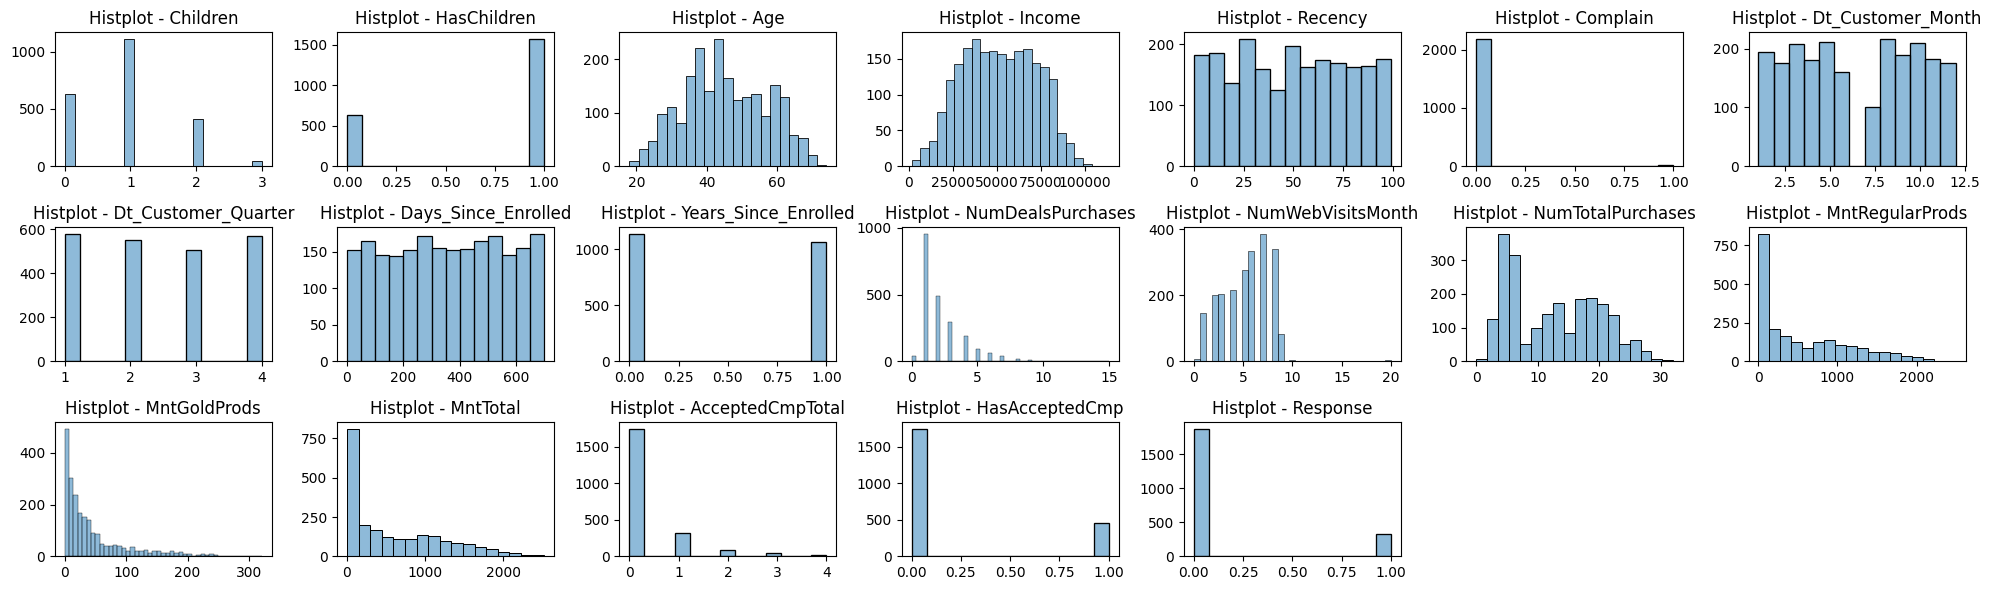

In [16]:
print('- Gráfico: Histograma.')

fn_charts_pandas.histplot(df_pd, numerical_features, num_cols = 7, height_figsize = 2)

plt.savefig(f'../images/outputs/charts/pyspark/nb06_histplot.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.3.3. Definindo o pré processamento das colunas de acordo com a distribuição dos seus dados

- **One Hot Encoder:** Indicado para colunas categóricas ou que possuem inteiros discretos.
- **Standard Scaler:** Indicado para colunas com distribuição semelhante à normal.
- **Power Transformer:** Indicado para colunas com assimetria dos dados.
- **Min-Max Scaler:** Indicado para colunas com distribuição uniforme dos dados.

In [17]:
one_hot_encoder_columns = [ 
    'Education',
    'Marital_Status',
    'AgeGroup',
    'Children',
    'HasChildren',
    'Complain',
    'Years_Since_Enrolled',
    'AcceptedCmpTotal',
    'HasAcceptedCmp',
    'Response',
]

standard_scaler_columns = [ 
    'Income',
    'Age',
]

power_transformer_columns = [ 
   'NumDealsPurchases',
   'NumWebVisitsMonth',
   'NumTotalPurchases',
   'MntRegularProds',
   'MntGoldProds',
   'MntTotal',
]

min_max_scaler_columns = [ 
    'Recency',
    'Dt_Customer_Month',
    'Dt_Customer_Quarter',
    'Days_Since_Enrolled',
]

### 06.3.4. Criando um dataset com o resultado do pré processamento

In [18]:
pre_processing = ColumnTransformer([ 

        ('one_hot_encoder', OneHotEncoder(), one_hot_encoder_columns), 

        ('standard_scaler', StandardScaler(), standard_scaler_columns),

        ('power_transformer', PowerTransformer(), power_transformer_columns),

        ('min_max_scaler', MinMaxScaler(), min_max_scaler_columns)
    
])

df_transformed = pd.DataFrame( 

    pre_processing.fit_transform(df_pd), 

    columns = pre_processing.get_feature_names_out() 

)

df_transformed.head(3) 

,one_hot_encoder__Education_2n Cycle,one_hot_encoder__Education_Basic,one_hot_encoder__Education_Graduation,one_hot_encoder__Education_Master,one_hot_encoder__Education_PhD,one_hot_encoder__Marital_Status_Partner,one_hot_encoder__Marital_Status_Single,one_hot_encoder__AgeGroup_18-30,one_hot_encoder__AgeGroup_31-45,one_hot_encoder__AgeGroup_46-60,one_hot_encoder__AgeGroup_61+,one_hot_encoder__Children_0,one_hot_encoder__Children_1,one_hot_encoder__Children_2,one_hot_encoder__Children_3,one_hot_encoder__HasChildren_0,one_hot_encoder__HasChildren_1,one_hot_encoder__Complain_0,one_hot_encoder__Complain_1,one_hot_encoder__Years_Since_Enrolled_0,one_hot_encoder__Years_Since_Enrolled_1,one_hot_encoder__AcceptedCmpTotal_0,one_hot_encoder__AcceptedCmpTotal_1,one_hot_encoder__AcceptedCmpTotal_2,one_hot_encoder__AcceptedCmpTotal_3,one_hot_encoder__AcceptedCmpTotal_4,one_hot_encoder__HasAcceptedCmp_0,one_hot_encoder__HasAcceptedCmp_1,one_hot_encoder__Response_0,one_hot_encoder__Response_1,standard_scaler__Income,standard_scaler__Age,power_transformer__NumDealsPurchases,power_transformer__NumWebVisitsMonth,power_transformer__NumTotalPurchases,power_transformer__MntRegularProds,power_transformer__MntGoldProds,power_transformer__MntTotal,min_max_scaler__Recency,min_max_scaler__Dt_Customer_Month,min_max_scaler__Dt_Customer_Quarter,min_max_scaler__Days_Since_Enrolled
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.775431,1.529871,-0.838557,-0.108417,0.817607,0.529534,-0.947497,0.455890,0.080808,0.454545,0.333333,0.547926
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.100188,1.102636,0.160834,-0.108417,-1.086982,-1.278761,-1.747891,-1.369621,0.868687,0.181818,0.000000,0.157368
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.098072,1.358977,0.160834,0.300240,1.583032,1.023607,1.279146,1.045743,0.292929,0.909091,1.000000,0.856938


### 06.3.5. Criando os gráficos dos Métodos do Cotovelo e da Silhueta

- Gráfico: Gráfico de Linha - Método do Cotovelo e Método da Silhueta.


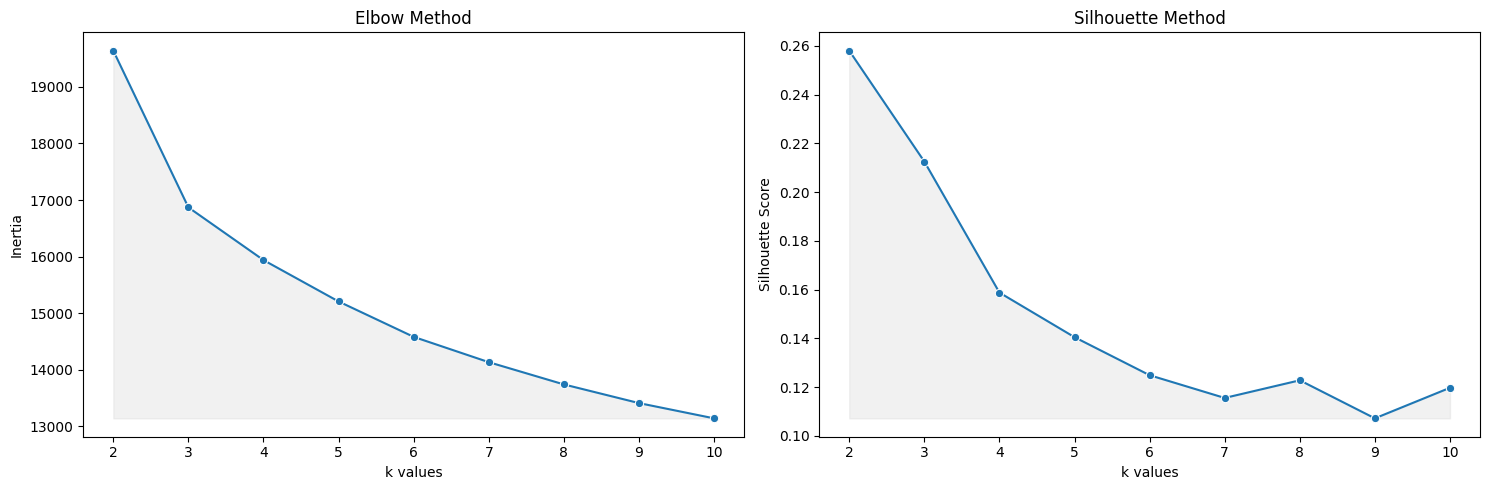

In [19]:
elbow = {}

silhouette = []

k_values = range(2, 11)

for i in k_values:

    kmeans = KMeans(n_clusters = i, random_state = consts.RANDOM_STATE, n_init = 10).fit(df_transformed)

    elbow[i] = kmeans.inertia_

    silhouette.append(silhouette_score(df_transformed, kmeans.labels_))

print('- Gráfico: Gráfico de Linha - Método do Cotovelo e Método da Silhueta.')

fn_charts_pandas.lineplot_elbow_silhouette(elbow, silhouette, k_values)

plt.savefig(f'../images/outputs/charts/pyspark/nb06_lineplot_elbow_silhouette.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.3.6. Interpretando os resultados do Elbow Method e do Silhouette Method

- **Elbow Method:** Nesse gráfico, é possível perceber o 'cotovelo' na posição 3, onde claramente há uma mudança de direção na plotagem do gráfico.
- **Silhouette Method:** Nesse gráfico, é possível identificar os maiores valores nas posições 2, 3 e 4, onde dessa forma representam os melhores valores a serem usados para identificação dos grupos.

**Conclusão:** Apesar de 2 ser o maior valor no gráfico de Silhouette Method, não é tão interessante assim separar os clientes em apenas 2 grupos, o que muitas das vezes pode ser feito através de clientes de alta e baixa renda. Portanto, corroborando o valor identificado no gráfico de Elbow Method, com o valor do 'cotovelo' identificado na posição 3, esse valor de 3 grupos acaba sendo o ideal nesse contexto para a segmentação dos clientes.

### 06.3.7. Criando o pipeline

In [20]:
pipeline = Pipeline([

        ('pre_processing', pre_processing), 

        ('dimensionality_reduction', PCA(n_components = 2, random_state = consts.RANDOM_STATE)),

        ('models', KMeans(n_clusters = 3, random_state = consts.RANDOM_STATE, n_init = 10))

])

### 06.3.8. Treinando o modelo

In [21]:
pipeline.fit(df_pd)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'Children', 'HasChildren',
                                                   'Complain',
                                                   'Years_Since_Enrolled',
                                                   'AcceptedCmpTotal',
                                                   'HasAcceptedCmp',
                                                   'Response']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Income', 'Age']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['NumDealsPurchases',
                                                   'NumWebVisitsMonth',
                                                   'NumTotalPurchases',
                                                   'MntRegularProds',
                                                   'MntGoldProds',
                                                   'MntTotal']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Recency',
                                                   'Dt_Customer_Month',
                                                   'Dt_Customer_Quarter',
                                                   'Days_Since_Enrolled'])])),
                ('dimensionality_reduction',
                 PCA(n_components=2, random_state=42)),
                ('models', KMeans(n_clusters=3, n_init=10, random_state=42))])

### 06.3.9. Evitando overfitting do modelo

- **Elbow e Silhouette Method:** Foram analisados os resultados dos gráficos de Elbow e Silhouette Method para se encontrar um número ótimo de clusters, não sendo um número nem tão baixo e nem tão alto de clusters. Além disso, os resultados de ambos os gráficos corroboraram a interpretação do outro.

## 06.4. Exportação dos dados

### 06.4.1. Criando o dataset clusterizado

In [22]:
df_clustered = df_pd.copy() 

df_clustered['Cluster'] = pipeline['models'].labels_ 

spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', 'true')

df_clustered = spark.createDataFrame(df_clustered)

df_clustered.show(5)

+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
| Education|Marital_Status|Children|HasChildren|Age|AgeGroup| Income|Recency|Complain|Dt_Customer_Month|Dt_Customer_Quarter|Days_Since_Enrolled|Years_Since_Enrolled|NumDealsPurchases|NumWebVisitsMonth|NumTotalPurchases|MntRegularProds|MntGoldProds|MntTotal|AcceptedCmpTotal|HasAcceptedCmp|Response|Cluster|
+----------+--------------+--------+-----------+---+--------+-------+-------+--------+-----------------+-------------------+-------------------+--------------------+-----------------+-----------------+-----------------+---------------+------------+--------+----------------+--------------+--------+-------+
|       PhD|        Single|       1|          1| 63|     61+|67680.0|      8|  

### 06.4.2. Visualizando a segmentação dos clientes entre os clusters

- Agrupamento da coluna: Cluster
+-------+----------+-----+
|Cluster|Percentage|Count|
+-------+----------+-----+
|0      |33.8      |745  |
|1      |41.3      |910  |
|2      |24.9      |550  |
+-------+----------+-----+



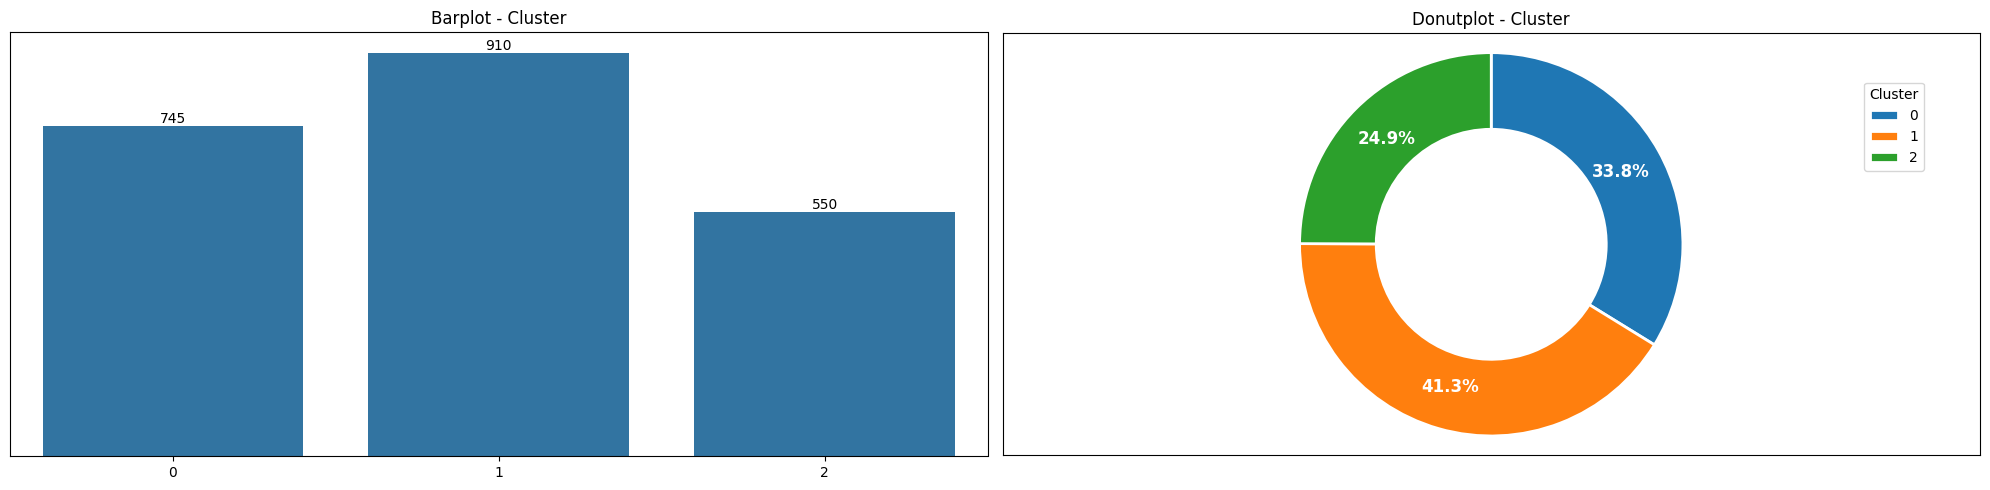

In [23]:
df_agg = fn_stats_pyspark.groupby_count(df_clustered, 'Cluster')

print(f'- Agrupamento da coluna: Cluster')

df_agg.show(truncate = False)

fn_charts_pandas.barplot_donutplot(df_agg.toPandas(), 'Cluster', 'Count')

plt.savefig(f'../images/outputs/charts/pyspark/nb06_barplot_donutplot_cluster.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.4.3. Salvando o dataset clusterizado em parquet e compactado em snappy

In [24]:
df_clustered.write \
    .format('parquet') \
    .mode('overwrite') \
    .option('compression', 'snappy') \
    .save(consts.DATASET_CLUSTERED_PYSPARK)

## 06.5. Análise exploratória dos dados

### 06.5.0. Convertendo o df_clustered PySpark para Pandas

In [25]:
df_pd_clustered = df_clustered.toPandas()

### 06.5.1. Criando um gráfico de dispersão por PCA para visualizar a segmentação dos grupos após a clusterização

- Gráfico: Gráfico de Dispersão.


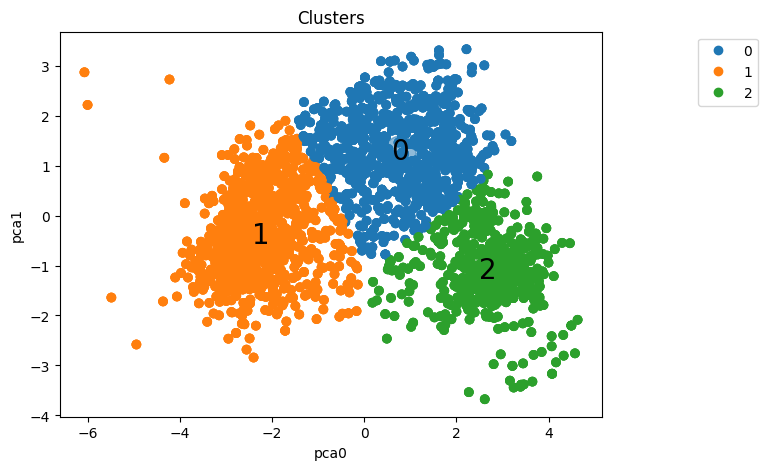

In [26]:
print('- Gráfico: Gráfico de Dispersão.')

df_pca = pd.DataFrame(pipeline[:-1].fit_transform(df_pd), columns = pipeline[:-1].get_feature_names_out())

fn_charts_pandas.scatterplot_clusters_2D(df_pca, df_pca.columns, 3, pipeline['models'].cluster_centers_, column_clusters = df_pd_clustered['Cluster'])

plt.savefig(f'../images/outputs/charts/pyspark/nb06_scatterplot_clusters_2d.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.5.2. Criando um gráfico de dispersão de acordo com os clusters para entender a distribuição dos dados nesse cenário

- Gráfico: Gráfico de Dispersão.

- Scatter Column: Income.

- Hue Column: Cluster.


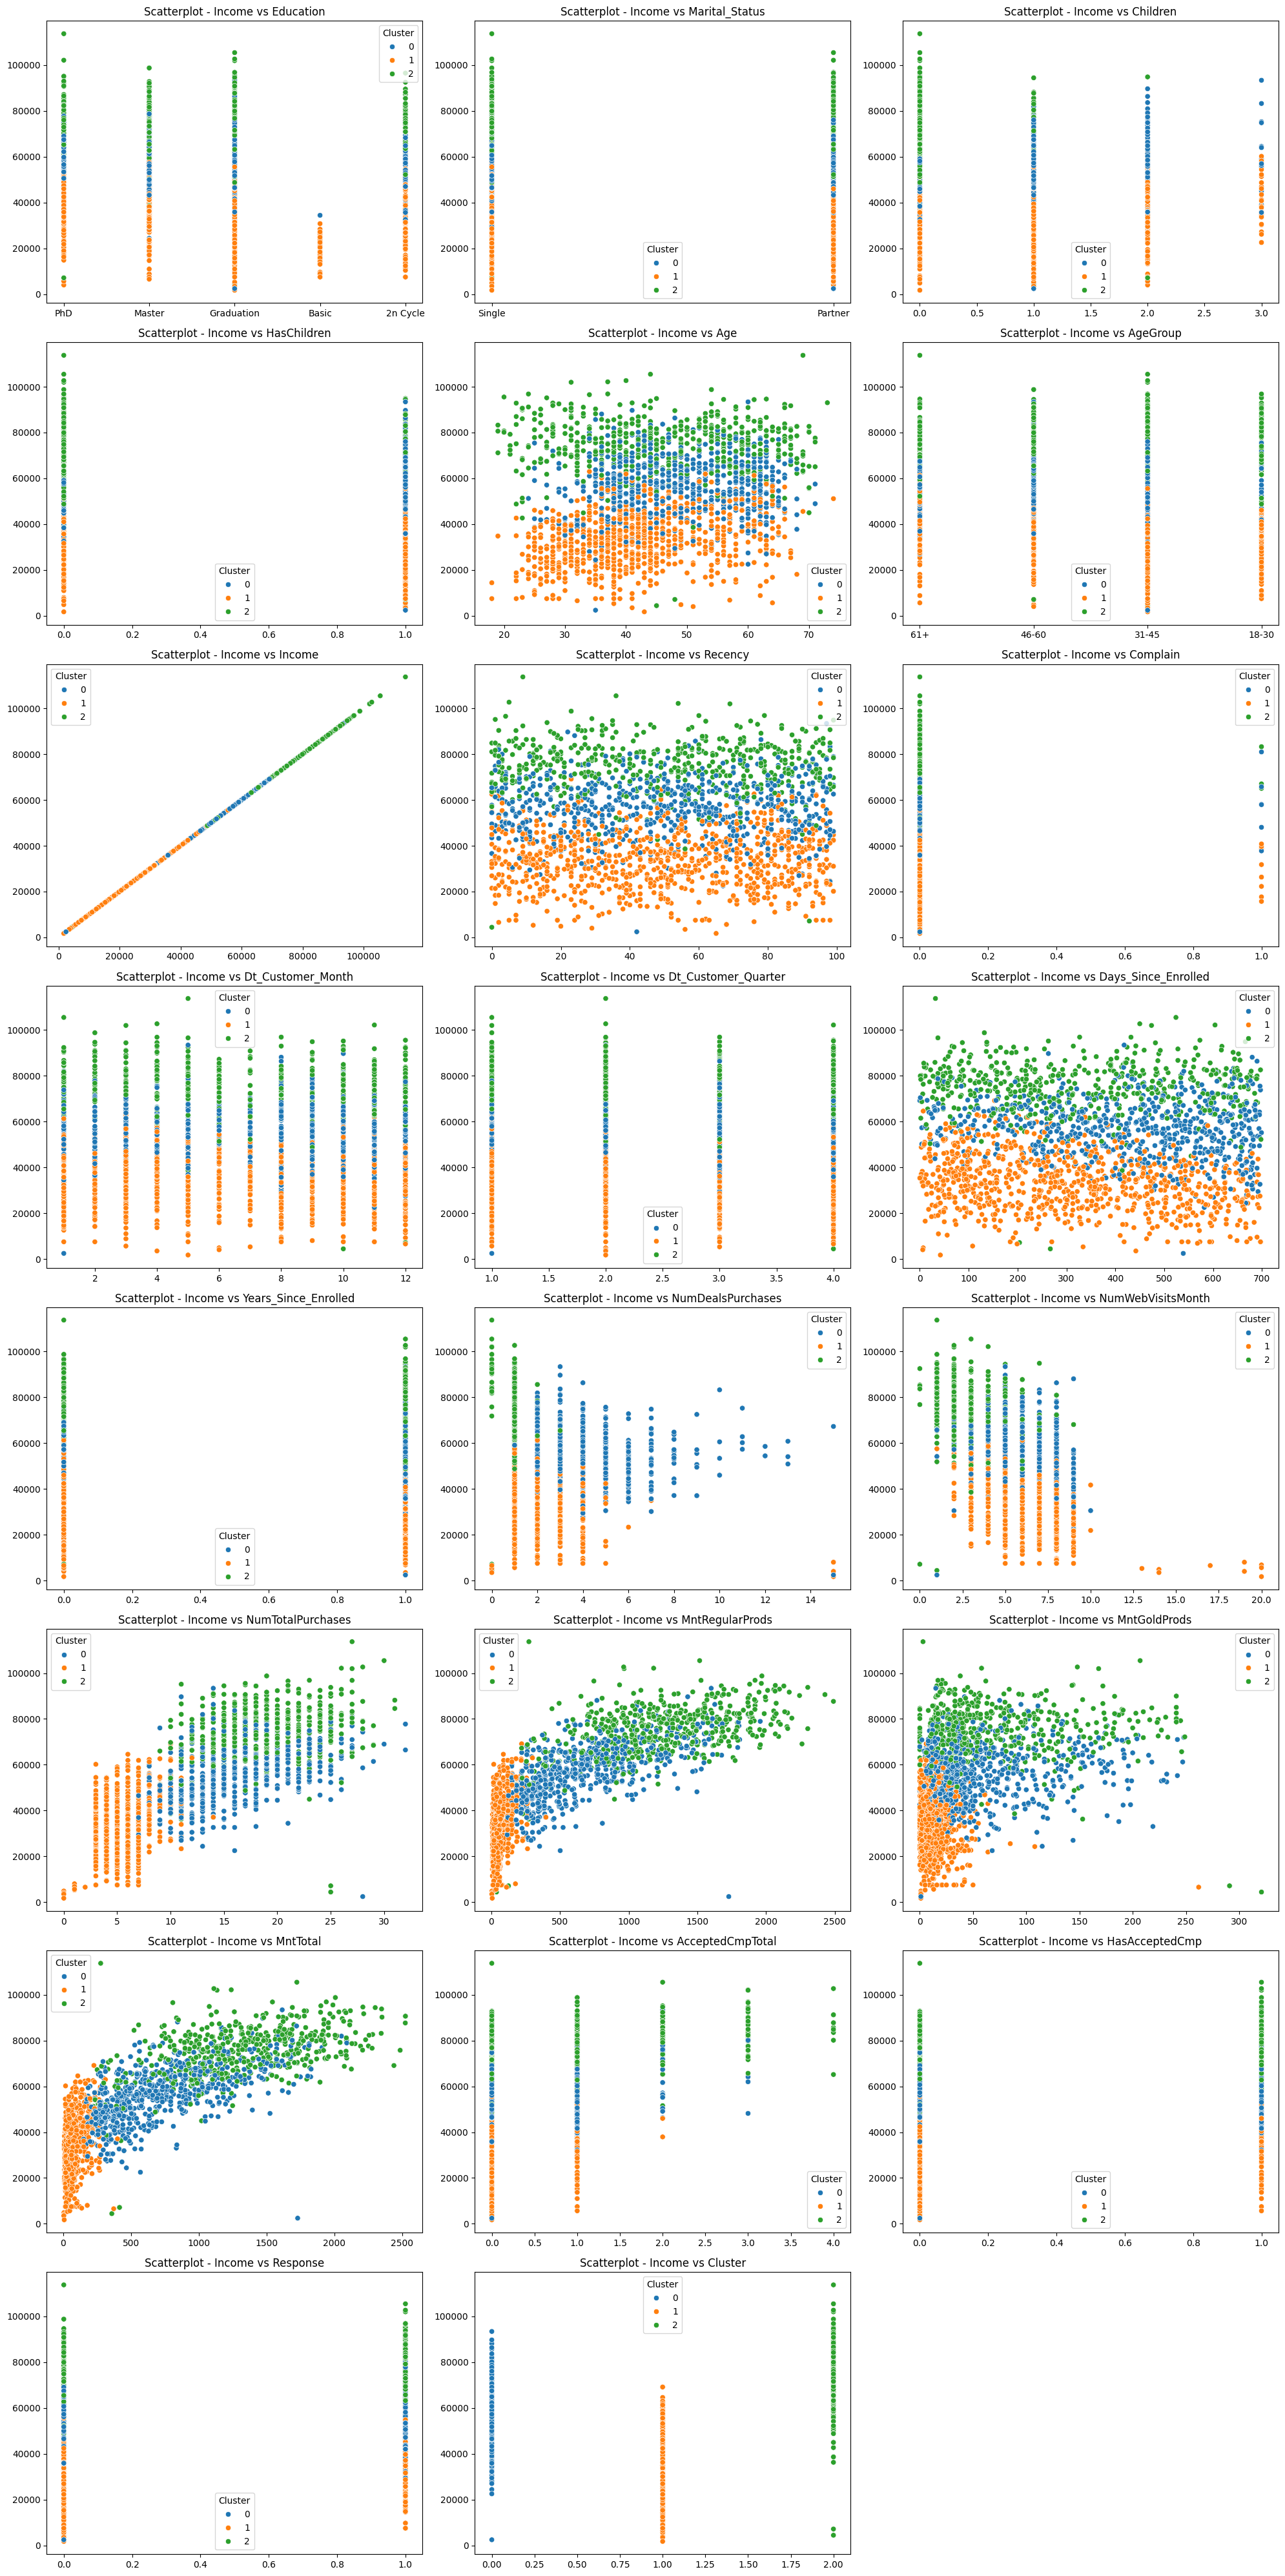

In [27]:
print('- Gráfico: Gráfico de Dispersão.\n')

print(f'- Scatter Column: Income.\n')

print(f'- Hue Column: Cluster.')

fn_charts_pandas.scatterplot(df_pd_clustered, df_pd_clustered.columns, 'Income', 'Cluster')

plt.savefig(f'../images/outputs/charts/pyspark/nb06_scatterplot_income.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.5.3. Criando histogramas de acordo com os clusters para extrair insights

- Gráfico: Histograma.


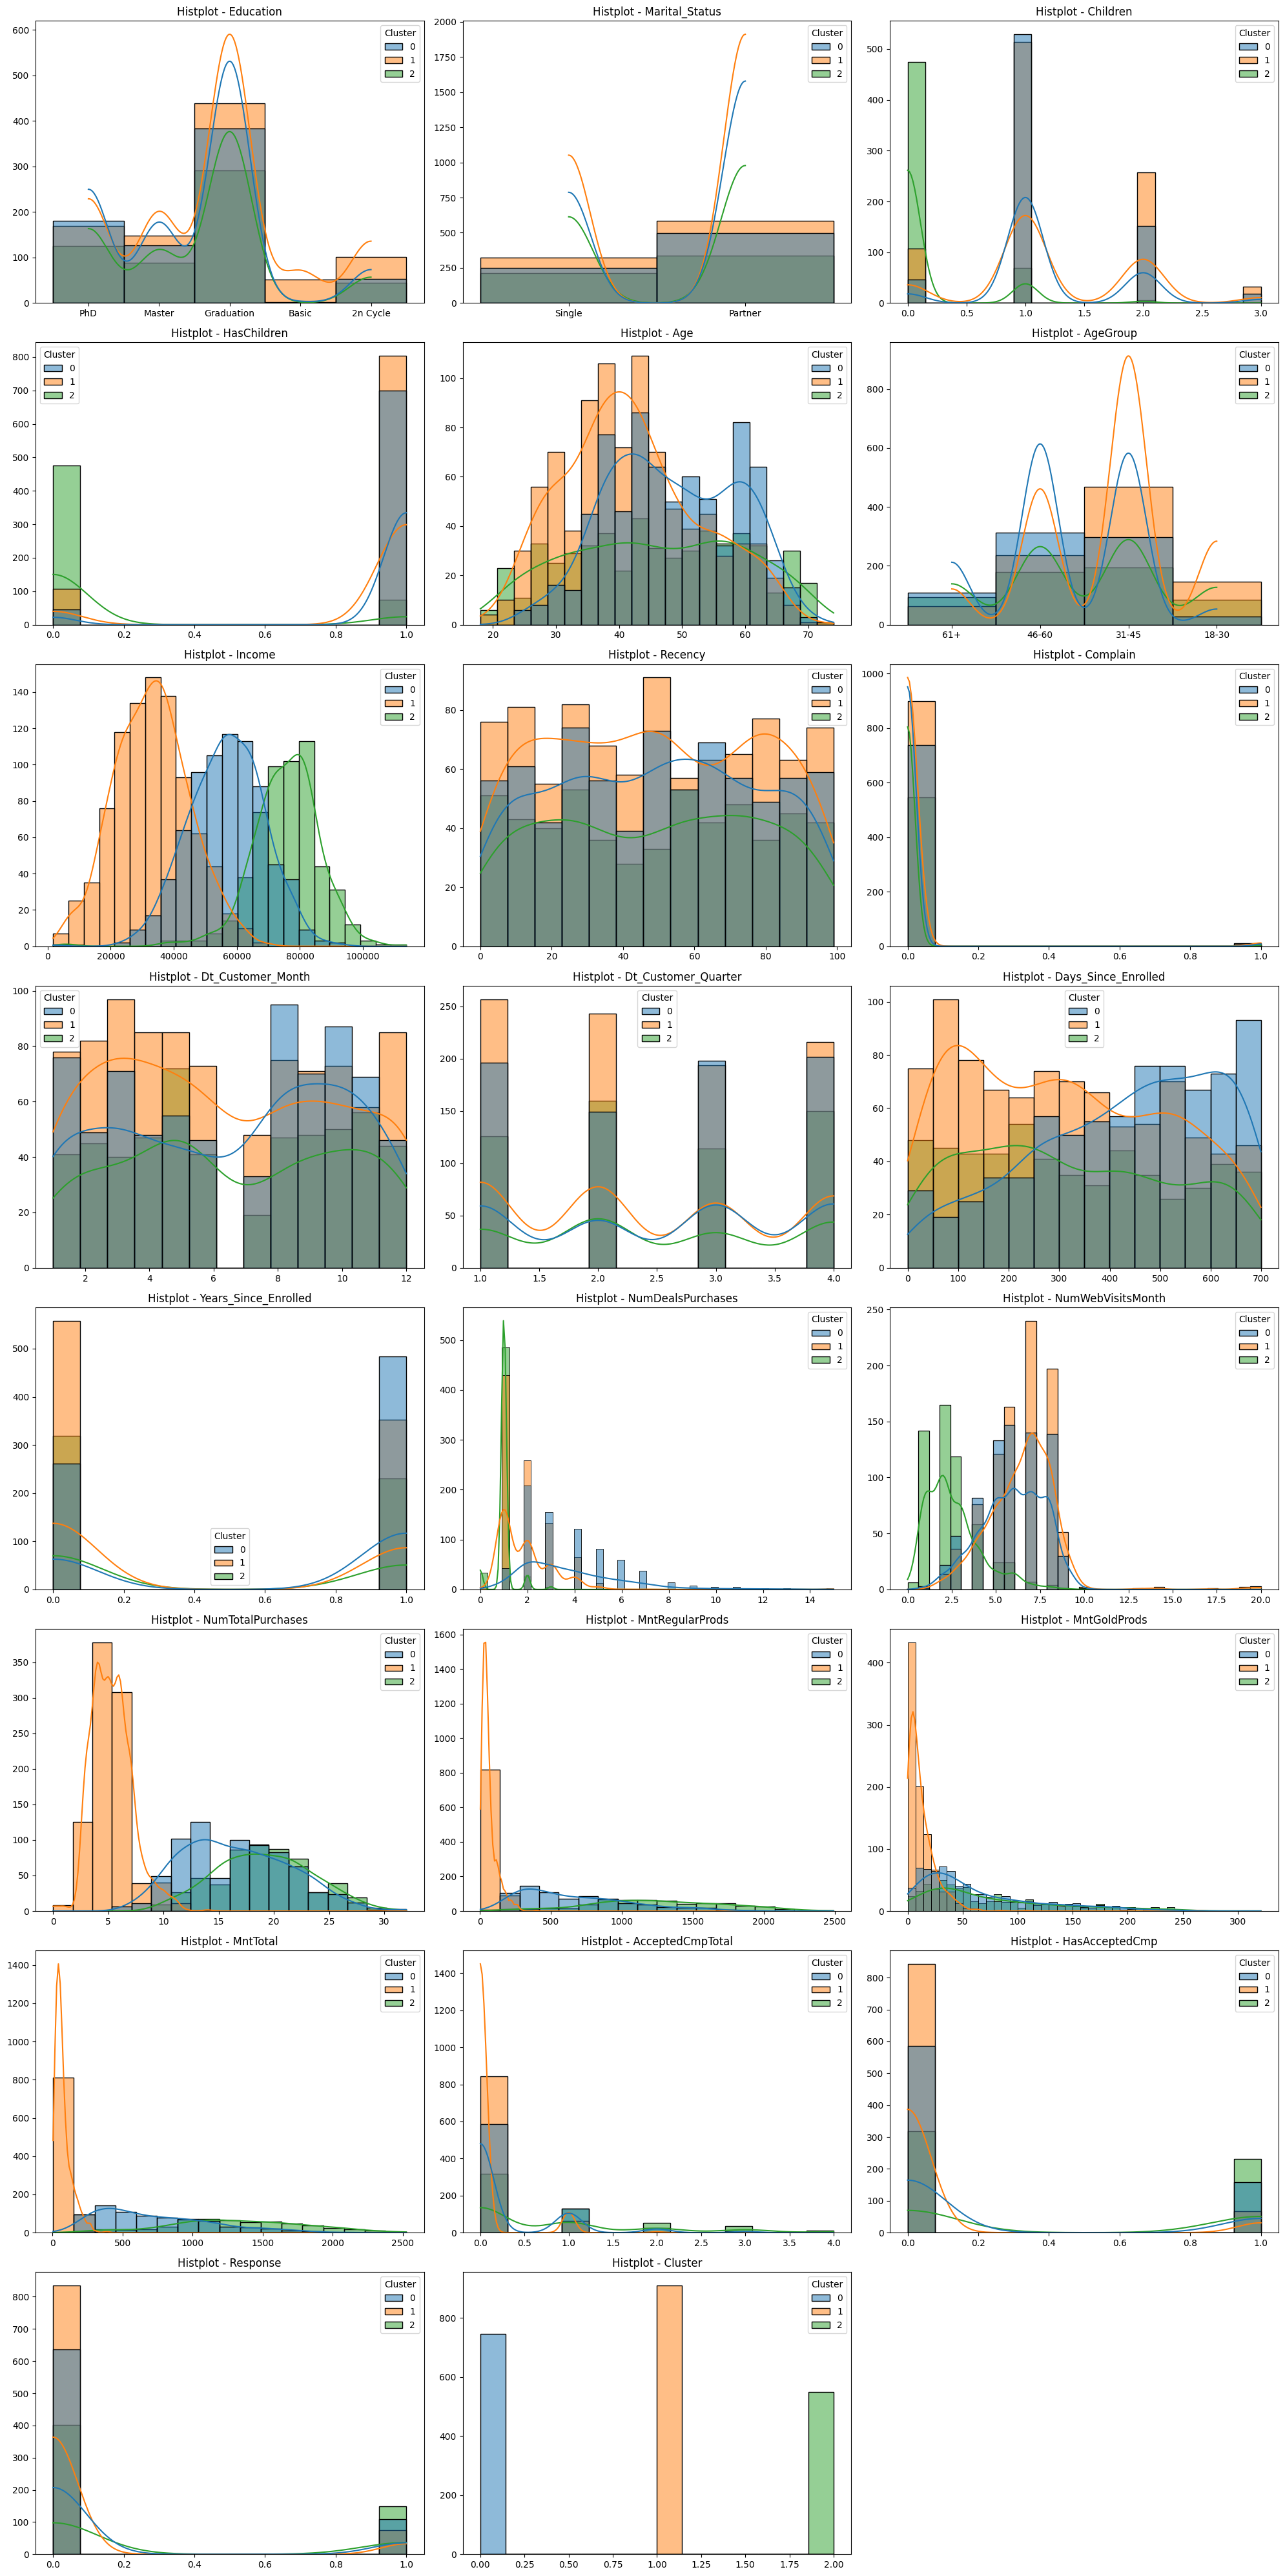

In [28]:
print('- Gráfico: Histograma.')

fn_charts_pandas.histplot(df_pd_clustered, df_pd_clustered.columns, 'Cluster', kde = True)

plt.savefig(f'../images/outputs/charts/pyspark/nb06_histplot_cluster.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.5.4. Criando diagramas de caixa de acordo com os clusters para corroborar os insights encontrados nos histogramas

- Gráfico: Diagrama de Caixa.


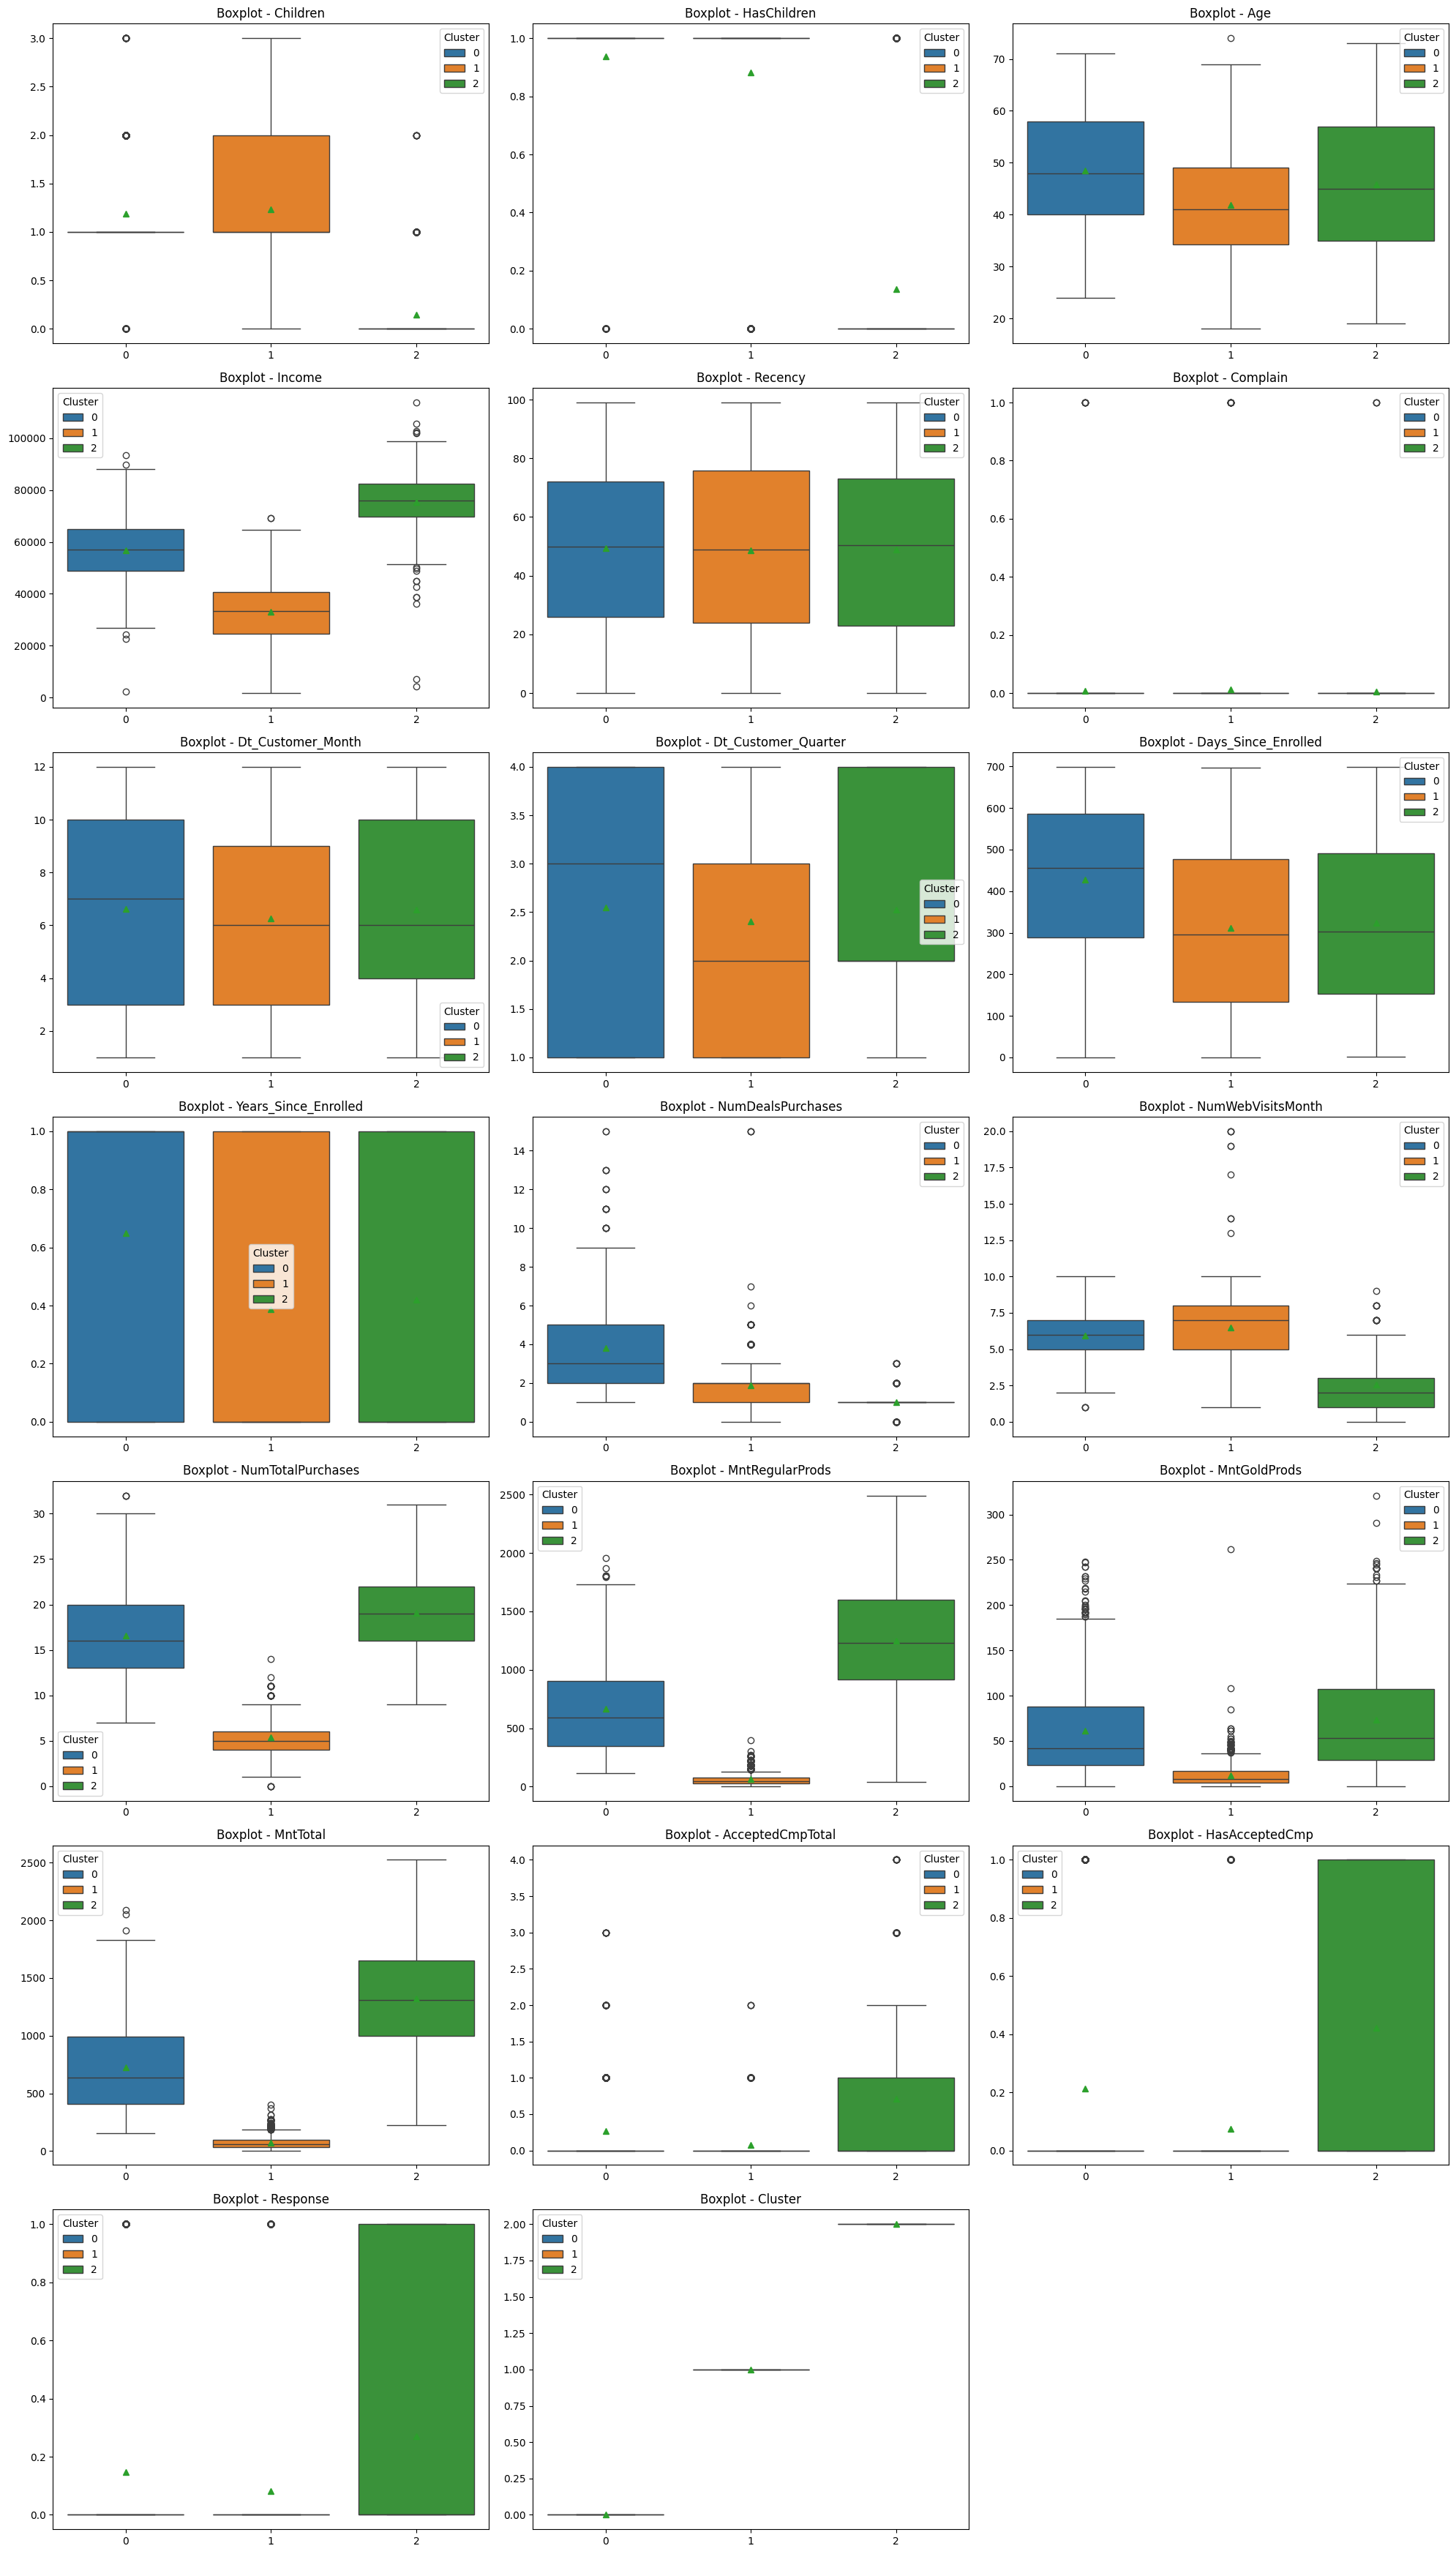

In [29]:
print('- Gráfico: Diagrama de Caixa.')

fn_charts_pandas.boxplot(df_pd_clustered, df_pd_clustered.select_dtypes(include = 'number').columns, 'Cluster', 'Cluster')

plt.savefig(f'../images/outputs/charts/pyspark/nb06_boxplot_cluster.png', format = 'png', dpi = 75, bbox_inches = 'tight', transparent = True)

plt.show()

### 06.5.5. Identificando os grupos após a clusterização

| Cluster 0                          | Cluster 1                                          | Cluster 2                         |
|------------------------------------|----------------------------------------------------|-----------------------------------|
| Renda alta                         | Renda baixa                                        | Renda média                       |
| Faz muitas compras                 | Faz poucas compras                                 | Faz muitas compras                |
| Gasta muito em compras             | Gasta pouco em compras                             | Gasta moderadamente em compras    |
| Provavelmente não tem filhos       | Provavelmente tem filhos                           | Provavelmente tem filhos          |
| Faz poucas compras com desconto    | Faz algumas compras com desconto                   | Faz muitas compras com desconto   |
| Visita pouco o site                | Visita muito o site                                | Visita muito o site               |
| Alta escolaridade                  | Único grupo que tem pessoas com escolaridade baixa | Alta escolaridade                 |
| **Aceita campanhas facilmente**    | **Dificilmente aceita campanhas**                  | **Pode aceitar campanhas**        |
| É cliente há menos tempo           | É cliente há menos tempo                           | É cliente há mais tempo           |